# Transfer Learning
## 2023-03-15

In [71]:
from abc import ABC, abstractmethod
from typing import List, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import MNIST

In [38]:
# --- BASE ---
class Module(ABC):
    @abstractmethod
    def forward(x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return self.forward(x)

    @property
    def out(self) -> torch.Tensor:
        return self._out

    @property
    def parameters(self) -> List[torch.Tensor]:
        return []


# --- LINEAR LAYER ---


class Linear(Module):
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        self._weight = torch.randn(fan_in, fan_out) / fan_in**0.5
        self._bias = torch.zeros(fan_out) if bias else None

    @property
    def weight(self) -> torch.Tensor:
        return self._weight

    @weight.setter
    def weight(self, x: torch.Tensor) -> None:
        self._weight = x

    @property
    def bias(self) -> torch.Tensor:
        return self._bias

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        self._out = x @ self._weight
        if self._bias is not None:
            self._out += self.bias
        return self._out

    @property
    def parameters(self) -> List[torch.Tensor]:
        return [self.weight] + ([self.bias] if self.bias is not None else [])


# --- ACTIVATION ---


class Tanh(Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._out = torch.tanh(x)
        return self._out


class ReLU(Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._out = torch.relu(x)
        return self._out


# --- BATCH NORM ---


class BatchNorm1d(Module):
    def __init__(self, fan_in: int, eps: float = 1e-5, momentum: float = 1e-1) -> None:
        self._eps = eps
        self._momentum = momentum
        self._training = True
        # parameters
        self._gamma = torch.ones(fan_in)
        self._beta = torch.zeros(fan_in)
        # buffers
        self._running_mean = torch.zeros(fan_in)
        self._running_var = torch.ones(fan_in)

    @property
    def training(self) -> bool:
        return self._training

    @training.setter
    def training(self, value: bool) -> None:
        self._training = value

    # a.shape [B, T, C, H, W]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self._training:
            if x.dim == 2:
                dim = 0
            elif x.dim == 3:
                dim = (0, 1)
            xmean = x.mean(dim=dim, keepdim=True)
            xvar = x.var(dim=dim, keepdim=True)
        else:
            xmean = self._running_mean
            xvar = self._running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self._eps)
        self._out = self._gamma * xhat + self._beta

        # updating buffers
        if self._training:
            self._running_mean = self._momentum * xmean + (1 - self._momentum) * self._running_mean
            self._running_var = self._momentum * xvar + (1 - self._momentum) * self._running_var

        return self._out

    @property
    def parameters(self) -> List[torch.Tensor]:
        return [self._gamma, self._beta]


# --- EMBEDDING ---


class Embedding(Module):
    def __init__(self, vocab_size: int, embedding_size: int) -> None:
        self._embedding = torch.randn(vocab_size, embedding_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._out = self._embedding[x]
        return self._out

    @property
    def parameters(self) -> List[torch.Tensor]:
        return [self._embedding]


# --- FLATTEN ---
class Flatten(Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._out = x.view(x.shape[0], -1)
        return self._out


class FlattenConsecutive(Module):
    def __init__(self, n: int = 1) -> None:
        self._n = n

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape
        x = x.view(B, T // self._n, C * self._n)
        if x.shape[1] == 1:
            x = x.squeeze(1)

        self._out = x
        return self._out


# --- SEQUENTIAL ---
class Sequential(Module):
    def __init__(self, *layers: Module) -> None:
        self._layers = list(layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self._layers:
            x = layer(x)
        self._out = x
        return x

    @property
    def layers(self) -> List[Module]:
        return self._layers

    @property
    def out_features(self) -> int:
        return self._layers[-1].weight.shape[-1]

    @property
    def parameters(self) -> List[torch.Tensor]:
        return [p for layer in self._layers for p in layer.parameters]

In [170]:
def evaluate_model(
    model: NumbersModel, test_dataloader: DataLoader, half_dataset: bool = False
) -> None:
    pred_labels: List[int] = []
    true_labels: List[int] = []

    with torch.no_grad():
        for batch in test_dataloader:
            x, y = batch
            if half_dataset:
                y = y // 2
            y_pred = model(x)
            pred_labels += y_pred.argmax(dim=-1).tolist()
            true_labels += y.tolist()

    print(classification_report(true_labels, pred_labels))

In [7]:
mnist_dataset = MNIST(root="", download=True, train=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 23379561.89it/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24541266.98it/s]


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 18896291.17it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3772381.93it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [24]:
# Splitting odd and even numbers from dataset

even_numbers: List[Tuple[torch.Tensor]] = []
odd_numbers: List[Tuple[torch.Tensor]] = []

for sample in mnist_dataset:
    label = sample[1]
    if label % 2 == 0:
        even_numbers.append(sample)
    else:
        odd_numbers.append(sample)

In [28]:
class NumbersDataset(Dataset):
    def __init__(self, data: List[Tuple[torch.Tensor]]) -> None:
        self._data = data

    def __len__(self) -> int:
        return len(self._data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self._data[idx]

In [30]:
train_even_numbers, test_even_numbers = train_test_split(
    even_numbers, test_size=0.2, random_state=42
)
train_odd_numbers, test_odd_numbers = train_test_split(odd_numbers, test_size=0.2, random_state=42)
train_numbers, test_numbers = train_test_split(
    even_numbers + odd_numbers, test_size=0.2, random_state=42
)

In [60]:
class NumbersModel:
    def __init__(self, encoder: Module, class_num) -> None:
        self._encoder = encoder
        self._classifier = Linear(encoder.out_features, class_num)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        x = self._encoder(x)
        x = self._classifier(x)
        return x

    def freeze(self) -> None:
        for p in self._encoder.parameters:
            p.requires_grad = False

    def unfreeze(self) -> None:
        for p in self.parameters:
            p.requires_grad = True

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return self.forward(x)

    @property
    def parameters(self) -> List[torch.Tensor]:
        return self._encoder.parameters + self._classifier.parameters

In [154]:
model = NumbersModel(
    Sequential(
        Linear(28 * 28, 128),
        ReLU(),
        Linear(128, 64),
        ReLU(),
        Linear(64, 64),
    ),
    class_num=10,
)

In [155]:
train_dataloader = DataLoader(NumbersDataset(train_numbers), batch_size=32, shuffle=True)
test_dataloader = DataLoader(NumbersDataset(test_numbers), batch_size=32, shuffle=False)

In [156]:
epochs = 15
lr = 0.001

lossi: List[float] = []

model.unfreeze()

for i in range(epochs):
    epoch_loss: float = []
    for batch in train_dataloader:
        x, y = batch
        y_pred = model(x)
        loss = F.cross_entropy(y_pred, y)

        for p in model.parameters:
            p.grad = None

        loss.backward()

        for p in model.parameters:
            p.data -= lr * p.grad

        epoch_loss.append(loss.item())
        lossi.append(loss.item())

    if i % 2 == 0:
        print(f"Epoch: {i}, Loss: {sum(epoch_loss) / len(epoch_loss)}")

Epoch: 0, Loss: 2.130190909544627
Epoch: 2, Loss: 0.9313966188430786
Epoch: 4, Loss: 0.5364955896933874
Epoch: 6, Loss: 0.4287623745203018
Epoch: 8, Loss: 0.3772725415279468
Epoch: 10, Loss: 0.3453031180600325
Epoch: 12, Loss: 0.3221344890892506
Epoch: 14, Loss: 0.3036738638704022


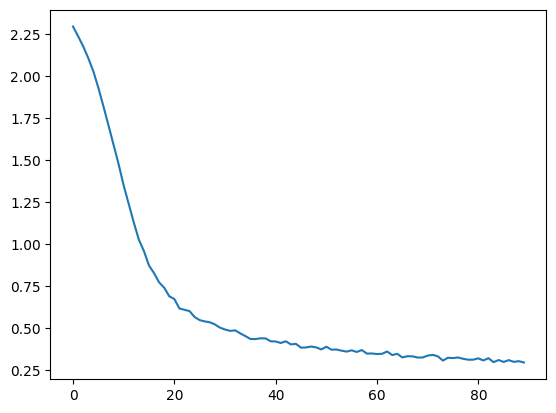

In [157]:
smoothing_gain = 250
plt.plot(torch.tensor(lossi).view(-1, smoothing_gain).mean(dim=1))

In [158]:
evaluate_model(model, test_dataloader)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1132
           1       0.95      0.97      0.96      1351
           2       0.92      0.87      0.89      1182
           3       0.89      0.89      0.89      1235
           4       0.90      0.92      0.91      1126
           5       0.88      0.88      0.88      1085
           6       0.94      0.95      0.94      1191
           7       0.92      0.93      0.92      1266
           8       0.89      0.87      0.88      1170
           9       0.89      0.89      0.89      1262

    accuracy                           0.91     12000
   macro avg       0.91      0.91      0.91     12000
weighted avg       0.91      0.91      0.91     12000



In [144]:
for batch in test_dataloader:
    sample = batch[0][2]
    break

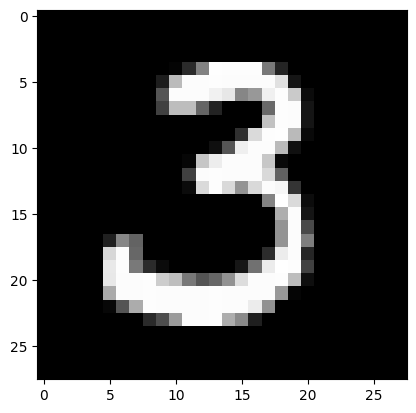

In [145]:
# RAW IMAGE
plt.imshow(sample.numpy().reshape(28, 28), cmap="gray")

In [148]:
# encoding image
with torch.no_grad():
    encoded_image = F.relu(model._encoder.layers[0](sample.view(1, -1)))

In [149]:
encoded_image.shape

torch.Size([1, 144])

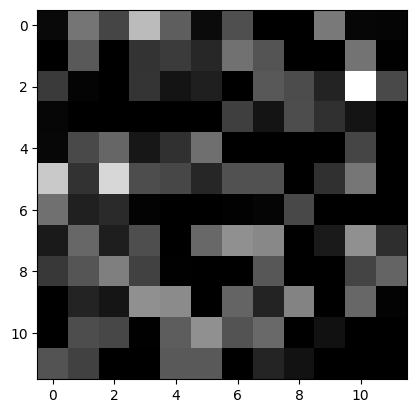

In [153]:
plt.imshow(encoded_image.numpy().reshape(12, 12), cmap="gray")

In [204]:
even_model = NumbersModel(
    Sequential(
        Linear(28 * 28, 128),
        ReLU(),
        Linear(128, 64),
        ReLU(),
        Linear(64, 64),
    ),
    class_num=5,
)

In [205]:
train_even_dataloader = DataLoader(NumbersDataset(train_even_numbers), batch_size=32, shuffle=True)
test_even_dataloader = DataLoader(NumbersDataset(test_even_numbers), batch_size=32, shuffle=False)

In [206]:
epochs = 15
lr = 0.001

lossi: List[float] = []

even_model.unfreeze()

for i in range(epochs):
    epoch_loss: float = []
    for batch in train_even_dataloader:
        x, y = batch
        y = y // 2
        y_pred = even_model(x)
        loss = F.cross_entropy(y_pred, y)

        for p in even_model.parameters:
            p.grad = None

        loss.backward()

        for p in even_model.parameters:
            p.data -= lr * p.grad

        epoch_loss.append(loss.item())
        lossi.append(loss.item())

    if i % 2 == 0:
        print(f"Epoch: {i}, Loss: {sum(epoch_loss) / len(epoch_loss)}")

Epoch: 0, Loss: 1.4394016215794778
Epoch: 2, Loss: 0.4958353877309861
Epoch: 4, Loss: 0.25649500348501736
Epoch: 6, Loss: 0.20054595103250125
Epoch: 8, Loss: 0.17589470593707995
Epoch: 10, Loss: 0.16077372159172848
Epoch: 12, Loss: 0.15039027300802107
Epoch: 14, Loss: 0.14227821986092543


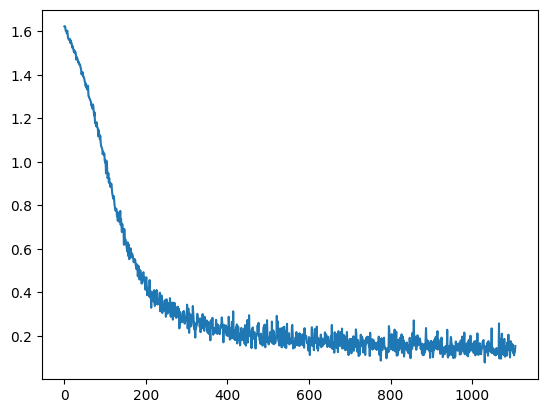

In [207]:
smoothing_gain = 10
plt.plot(torch.tensor(lossi).view(-1, smoothing_gain).mean(dim=1))

In [208]:
evaluate_model(even_model, test_even_dataloader, True)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1162
           1       0.95      0.93      0.94      1225
           2       0.95      0.96      0.96      1126
           3       0.94      0.96      0.95      1141
           4       0.96      0.94      0.95      1245

    accuracy                           0.95      5899
   macro avg       0.95      0.95      0.95      5899
weighted avg       0.95      0.95      0.95      5899



In [209]:
odd_model = NumbersModel(
    Sequential(
        Linear(28 * 28, 128),
        ReLU(),
        Linear(128, 64),
        ReLU(),
        Linear(64, 64),
    ),
    class_num=5,
)

In [210]:
train_odd_dataloader = DataLoader(NumbersDataset(train_odd_numbers), batch_size=32, shuffle=True)
test_odd_dataloader = DataLoader(NumbersDataset(test_odd_numbers), batch_size=32, shuffle=False)

In [211]:
epochs = 15
lr = 0.001

lossi: List[float] = []

odd_model.unfreeze()

for i in range(epochs):
    epoch_loss: float = []
    for batch in train_odd_dataloader:
        x, y = batch
        y = y // 2
        y_pred = odd_model(x)
        loss = F.cross_entropy(y_pred, y)

        for p in odd_model.parameters:
            p.grad = None

        loss.backward()

        for p in odd_model.parameters:
            p.data -= lr * p.grad

        epoch_loss.append(loss.item())
        lossi.append(loss.item())

    if i % 2 == 0:
        print(f"Epoch: {i}, Loss: {sum(epoch_loss) / len(epoch_loss)}")

Epoch: 0, Loss: 1.446359330985993
Epoch: 2, Loss: 0.6318914005593891
Epoch: 4, Loss: 0.3464436091258048
Epoch: 6, Loss: 0.2637638232889213
Epoch: 8, Loss: 0.22887621964004531
Epoch: 10, Loss: 0.2088287390065459
Epoch: 12, Loss: 0.1949773573073733
Epoch: 14, Loss: 0.18424260356313357


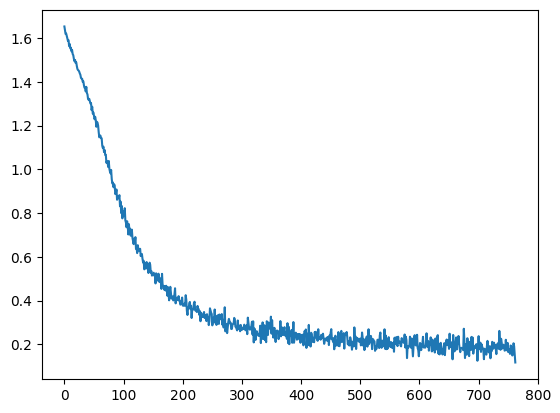

In [213]:
smoothing_gain = 15
plt.plot(torch.tensor(lossi).view(-1, smoothing_gain).mean(dim=1))

In [214]:
evaluate_model(odd_model, test_odd_dataloader, True)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1320
           1       0.95      0.90      0.92      1244
           2       0.91      0.94      0.93      1069
           3       0.94      0.94      0.94      1286
           4       0.93      0.93      0.93      1183

    accuracy                           0.94      6102
   macro avg       0.94      0.94      0.94      6102
weighted avg       0.94      0.94      0.94      6102



In [215]:
odd_model = even_model

odd_model._classifier = Linear(odd_model._encoder.out_features, 5)

In [216]:
evaluate_model(odd_model, test_odd_dataloader, True)

              precision    recall  f1-score   support

           0       0.03      0.02      0.02      1320
           1       0.08      0.00      0.00      1244
           2       0.46      0.01      0.01      1069
           3       0.35      0.93      0.51      1286
           4       0.00      0.01      0.01      1183

    accuracy                           0.20      6102
   macro avg       0.18      0.19      0.11      6102
weighted avg       0.18      0.20      0.11      6102



In [217]:
epochs = 15
lr = 0.001

lossi: List[float] = []

odd_model.unfreeze()
odd_model.freeze()

for i in range(epochs):
    epoch_loss: float = []
    for batch in train_odd_dataloader:
        x, y = batch
        y = y // 2
        y_pred = odd_model(x)
        loss = F.cross_entropy(y_pred, y)

        for p in odd_model.parameters:
            p.grad = None

        loss.backward()

        for p in odd_model.parameters:
            if p.requires_grad:
                p.data -= lr * p.grad

        epoch_loss.append(loss.item())
        lossi.append(loss.item())

    if i % 2 == 0:
        print(f"Epoch: {i}, Loss: {sum(epoch_loss) / len(epoch_loss)}")

Epoch: 0, Loss: 1.3185225278334411
Epoch: 2, Loss: 0.9002613265111281
Epoch: 4, Loss: 0.8060244348383512
Epoch: 6, Loss: 0.7588903821936441
Epoch: 8, Loss: 0.7291322172000555
Epoch: 10, Loss: 0.7079535507124655
Epoch: 12, Loss: 0.6918326449894187
Epoch: 14, Loss: 0.6783405345123686


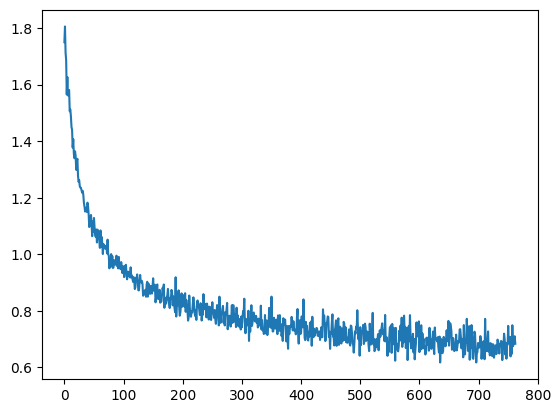

In [219]:
smoothing_gain = 15
plt.plot(torch.tensor(lossi).view(-1, smoothing_gain).mean(dim=1))

In [221]:
evaluate_model(odd_model, test_odd_dataloader, True)

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1320
           1       0.76      0.70      0.73      1244
           2       0.69      0.64      0.67      1069
           3       0.79      0.73      0.76      1286
           4       0.77      0.80      0.78      1183

    accuracy                           0.78      6102
   macro avg       0.77      0.77      0.77      6102
weighted avg       0.77      0.78      0.77      6102



In [222]:
epochs = 10
lr = 0.0001

lossi: List[float] = []

odd_model.unfreeze()

for i in range(epochs):
    epoch_loss: float = []
    for batch in train_odd_dataloader:
        x, y = batch
        y = y // 2
        y_pred = odd_model(x)
        loss = F.cross_entropy(y_pred, y)

        for p in odd_model.parameters:
            p.grad = None

        loss.backward()

        for p in odd_model.parameters:
            if p.requires_grad:
                p.data -= lr * p.grad

        epoch_loss.append(loss.item())
        lossi.append(loss.item())

    if i % 2 == 0:
        print(f"Epoch: {i}, Loss: {sum(epoch_loss) / len(epoch_loss)}")

Epoch: 0, Loss: 0.647484435049297
Epoch: 2, Loss: 0.5630445241693744
Epoch: 4, Loss: 0.5059134375845933
Epoch: 6, Loss: 0.464096720690496
Epoch: 8, Loss: 0.43177942966805527


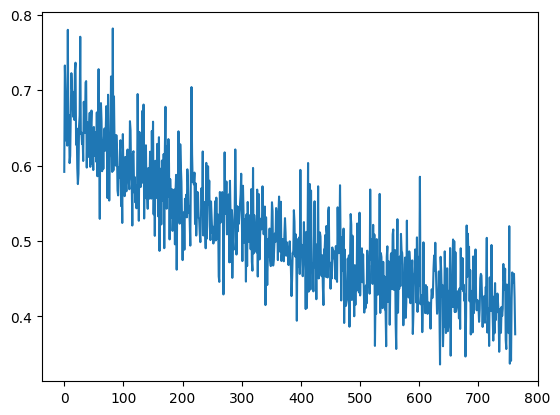

In [224]:
smoothing_gain = 10
plt.plot(torch.tensor(lossi).view(-1, smoothing_gain).mean(dim=1))

In [225]:
evaluate_model(odd_model, test_odd_dataloader, True)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1320
           1       0.87      0.82      0.84      1244
           2       0.81      0.83      0.82      1069
           3       0.90      0.88      0.89      1286
           4       0.87      0.88      0.87      1183

    accuracy                           0.88      6102
   macro avg       0.87      0.88      0.87      6102
weighted avg       0.88      0.88      0.88      6102

